# Neural Networks Part 3

*Original course notes [here](https://cs231n.github.io/neural-networks-3/)*

## Learning: Best Practices and What to Look Out For

1. Use the **centered formula** for numerical gradient
    - centered formula has an error term of $O(h^2)$, whereas traditional formula has $O(h)$ (can be shown via Taylor expansion of $f(x+h)$ and $f(x-h)$)
    - set h to ~1e-5

2. Use **relative error** during gradient check to compute a more statistically meaningful threshold for determining whether the analytical and numerical values are the "same"

3. Use **double precision (64-bit)** floats during error check

4. **Scale** the relative error to within the "active" range of floating point
    - the absolute value difference between the numerical and analytical gradient should not be smaller than about 1e-10
    - this is because it is common to normalize the loss over the entire batch (by dividing by batch size, for example)
    - therefore, if the abssolute differences are already very small, further dividing them can cause numerical instability
    - if the differences are too small, you should scale them by some $1^n$, where n will allow the float exponent to be 0 (for example, scale 5e-10 by 1e10)

5. **Kinks** in the objective function
    - kinks are problematic because where the analytical gradient may be 0, the numerical gradient is computed by a secant line which skips over the kink, resulting in a non-zero value
        - see `svm.ipynb`, inline Q1
    - we can detect when a kink is crossed over by checking if the "winner" of the objective changes from f(x+h) to f(x-h)
        - for example, if $f_1 = f(x+h) < 0$, then the "winner" of $\text{max}(0, f_1) = 0$.
        - if $f_2 = f(x-h) > 0$, the winner of $\text{max}(0, f_2)$ changes from the first to the second argument, so we know the kink is in between $x-h$ and $x+h$

6. Gradient check with **fewer datapoints**
    - this speeds up the computation time
    - it also makes it less likely that you'll run through the kink, since you are checking fewer points along the function

7. **Smaller h is not always better**
    - too small a value for h can cause numeric instability
    - also, increasing or decreasing h by an order of magnitude may result in very different gradients being computed
        - visually, similar to issues introduced by kinks, depending on the function, the slope of the secant between x+h and x-h can vary significantly

8. Perform gradient check **once loss starts to decrease**
    - the specific points for which we check the gradient are usually chosen at random
    - a correct gradient at a specific point does not necessarily mean a globally correct analytical implementation
    - we should not gradient check at the first iteration, where the weights are initalized randomly
        - this is because we could be learning on weights which are not very representative of the data
        - for example, if the weights are randomly initialized to very small values, the gradients will be close to 0, and patterns in the gradient could emerge
        - the emergence of a pattern doesn't give us much info about whether the gradient was implemented correctly, because an incorrect implementation could produce this pattern

9. Check the gradient **without regularization first**
    - it is not uncommon for the regularization loss to overwhelm the data loss
    - if that happens, we lose information about correctness of the loss gradient, since the regularization gradient is simpler to implement

10. **Check regularization loss after data loss**
    - this could be done by totally removing data loss
    - we could also increase the regularization strength such that the effects of an incorrect implementation become noticeable

11. **Turn off augmentations** such as dropout
    - non-deterministic augmentations especially will have unpredictable effects on the gradient
    - the drawback to turning off augmentations is that we can't gradient check them anymore, e.g. backpropagation of dropout
        - this can be mitigated by setting a random seed before computing $f(x+h), f(x-h)$, and the numerical gradient

12. **Check a few dimensions from each parameter**
    - merging all parameters into a giant vector, then randomly sampling the gradients to be checked, could result in skipping over entire parameters
        - this could be the case with bias, for example, which has far fewer terms than weights
    - instead, randomly sample dimensions within each parameter

## Sanity Checks Before Learning

1. **Use small initial parameters to check loss**
    - set regularization strength to zero during this initial check
    - the output should match a pre-computable value that makes sense in the context of the task
        - for example, in CIFAR-10, where we have 10 classes, we expect the softmax classifier to about a score close to $-\log(0.1)$, as explained in `softmax.ipynb`, inline Q1
        - notice with small initial weights, the scores should be fairly diffuse as well, which is why setting them to small initial values is important

2. **Loss should increase as regularization strength increases**

3. **Overfit a tiny subset of data**
    - the model should be able to achieve 0 loss on a small (~20) subset of training data
    - only once we can overfit this subset should we move on to the entire training set
    - note that passing this sanity check does not guarantee a correct implementation
        - if there is some bug in either our implementation or the data points we selected, we could be overfitting a bad implementation, which won't generalize to the whole dataset

## Sanity Checks During Learning

loss plots

train/val acc plots
- heavy overfitting
    - increase regularization (more dropout, stronger weight penalty, etc.)
    - collect more (and better) data
- slight overfitting
    - increase capacity by increasing # params

ratio of updates:weights
- want about -1e-3
- higher/lower indicates learning rate might be too high/low

## Parameter Updates

### Vanilla Gradient Descent

**Formula**

$$W_t = W_{t-1} -\alpha \nabla_{W_{t-1}} L$$

- update each position by a small step *against* the gradient (since gradient defines steepest *ascent*)

### Momentum Update

**Inefficiencies with SGD**
- for the sake of easier visualization, suppose we are in a 3-D space
- from the 3-D "hills" defined by our objective function, we have the 2-D elliptical level sets (a level set is just the set of all points that evaluate to a constant)
- **note:** the gradient is perpendicular to the level set ([proof](http://mathonline.wikidot.com/the-perpendicularity-of-the-gradient-at-a-point-on-a-level-c))
- this is why the gradient can oscillate frequently as it tries to find a minimum, which means more iterations are required to get there
- this [article](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_7_Problems.html) explains these intuitive weaknesses of vanilla GD in greater detail

**Physics Analogy**
- we have $F = -\nabla U = ma$, where $U = mgh$ is the gravitational potential energy
- so if we think of our loss function as the potential energy of our ball, then the force experienced by the ball is the negative gradient of the loss function
- this makes sense because, in the physics view, we want to maximize the force experienced by the ball, to get it downhill as quickly as possible
- now the similarity to SGD is clear
- however, we use the gradient to update velocity, instead of position, and then use the new velocity to update position

**Formula**
$$ v_t = \beta v_{t-1} + (1-\beta) \nabla_{W_{t-1}}L, \beta \in [0,1] $$
$$ W_t = W_{t-1} + \alpha v_t $$

- $\beta$ - "momentum" (although not literally, as it acts more like a coefficient of friction, proportionally scaling the kinetic energy of the ball as it rolls downhill, i.e. decay rate)
    - 0.9 is a good default value; common cross-validation values are [0.5, 0.9, 0.95, 0.99]
- $v$ - velocity  
- $t$ - iteration
- $\alpha$ - learning rate
- $W$ - weight matrix      

**Understanding $\beta$**
- we can think of $\beta$ as affecting "how far back we remember" 
- this is because, expanding the recursive relation of $v_t$ (see [derivation](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d)), we see that the older a term is, the smaller it becomes, due to exponential scaling

$$v_t = \sum_{i=0}^{t}\beta^{i}(1-\beta) \nabla_{W_{t-i}} L$$

- thus each update is computed as a **weighted running sum** of all the previous updates
- eventually, terms below a certain threshold will have neglible effect on the update, and are "forgotten"
- we can also think of $\beta$ as **how much of the previous velocity we want to retain** from one iteration to the next
- when $\beta = 0$, we just have vanilla GD (i.e., the previous velocity has 0 effect on the update)
- when $\beta = 1$, our initial velocity $v_0$ (assuming $v_0 > 0$) will never decay
- notice that for larger $\beta$, the coefficients do not decrease as quickly, so, intuitively, more of the previous terms have a non-negligble affect on the next update

**Momentum  > SGD**
- we explained earlier how SGD was inefficient because the direction per iteration can oscillate rapidly
- we can think of momentum as preserving more (compared SGD) of the previous velocity's direction
- this way, the change in direction per iteration is not so sharp
- the smoother trajectory towards the minimum allows us to skip over other local minima ("bumps" along the way)
- see [Why Momentum Really Works](https://distill.pub/2017/momentum/) for much more detailed explanation
> When $\beta$ is too small (e.g. in Gradient Descent, $\beta = 0$), we're over-damping. The particle is immersed in a viscous fluid which saps it of its kinetic energy at every timestep.

- this provides better intuition for how momentum improves on SGD, 
avoiding worse local minima which SGD may converge to

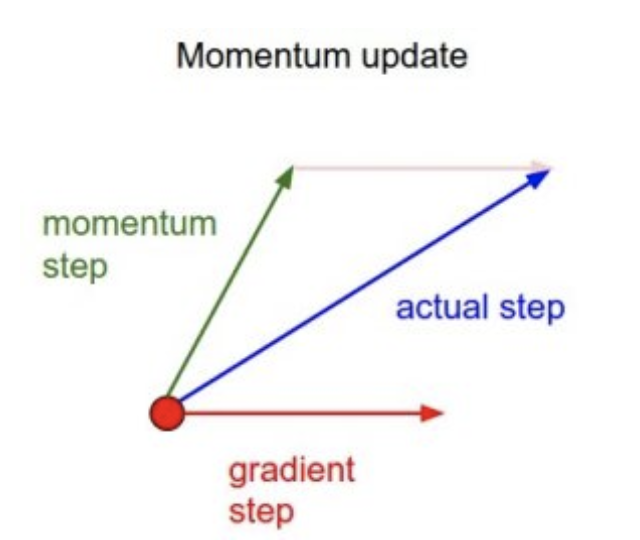

In [43]:
from IPython.display import Image
Image(filename="../images/momentum_update.png", width=350) 

Visual interpretation of how momentum changes affects the next step. (Source: [Stanford CS231n](https://cs231n.github.io/neural-networks-3))

In SGD, we would take a step (scaled by learning rate) in the direction of the red vector, the gradient. However, with momentum update, we preserve some of the previous velocity, and use that *add* that to the gradient vector, resulting in a step vector somewhere in between.

**Bias Correction**
- the result of our formula depends heavily on $v_0$, which we initialize to 0 (this is what is meant by "bias towards zero")
- the bias is corrected by dividing the momentum by $(1 - \beta^t)$ after each update (see [StackExchange](https://stats.stackexchange.com/questions/232741/why-is-it-important-to-include-a-bias-correction-term-for-the-adam-optimizer-for) and [YouTube](https://youtu.be/-0ZMU-gnm2g?t=341) (the explanations are for Adam optimizer, but the logic still applies)
- that is, **in expectation**, our estimated velocity will be the same as the true velocity
- intuitively, we are converting our running sum into a **running average**

### Nesterov Momentum

This is a variation of momentum update which computes the gradient step starting from the end of the momentum step, rather than computing both gradient and momentum at the starting point. Nesterov momentum theoretically converges more quickly than standard momentum, and has been shown in practice to consistently outperform standard momentum update.

**Formula**

The formula remains the same, except we compute an intermediate "look-ahead" position (denoted by $W'$ below) using the previous velocity. We then use this intermediate position to find the updated velocity $v_t$. Finally, we update the position using $v_t$, like we do in regular momentum update.

1. Compute temporary momentum-shifted position: $W' = W_{t-1} + \beta v_{t-1}$
2. Nesterov momentum: $v_t = \beta v_{t-1} + (1-\beta) \nabla_{W'} L$
3. Update position: $W_t = W_{t-1} - \alpha v_t $

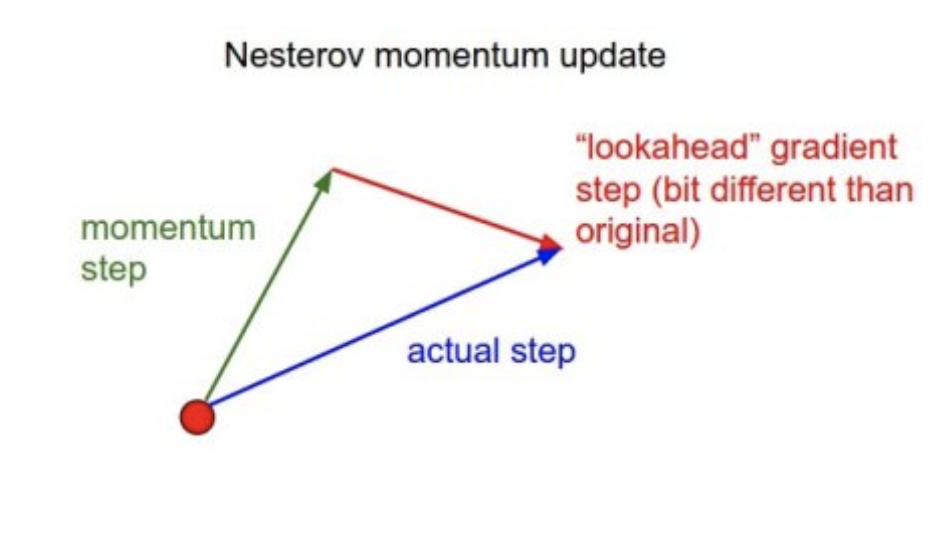

In [63]:
Image(filename="../images/nesterov.png")

By computing the gradient after taking the momentum step, the actual step is "pulled down" towards the original gradient moreso than in normal momentum, correcting potential overshooting from the gradient at the original position. (Source: [Stanford CS231n](https://cs231n.github.io/neural-networks-3))

**Nesterov > Standard Momentum**
- if the momentum vector "overshoots" (i.e. skips past the minima, possibly ending up in a worse position), computing the gradient at the look-ahead position "pulls us" back closer in the direction of the gradient at the original point
- this results in a smoother trajectory (i.e. fewer oscillations) since the distance we move less vertically, compared to standard momentum
- because of Nesterov momentum's correcting properties, it performs better than standard momentum for larger learning rates; the correcting also allows for larger $\beta$, which means we can update the loss farther horizontally, *and* have fewer oscillations
- note that for smaller learning rates, their performance is theoretically equal ([Sutskever1 et al., Theorem 2.1](https://www.cs.toronto.edu/~fritz/absps/momentum.pdf))

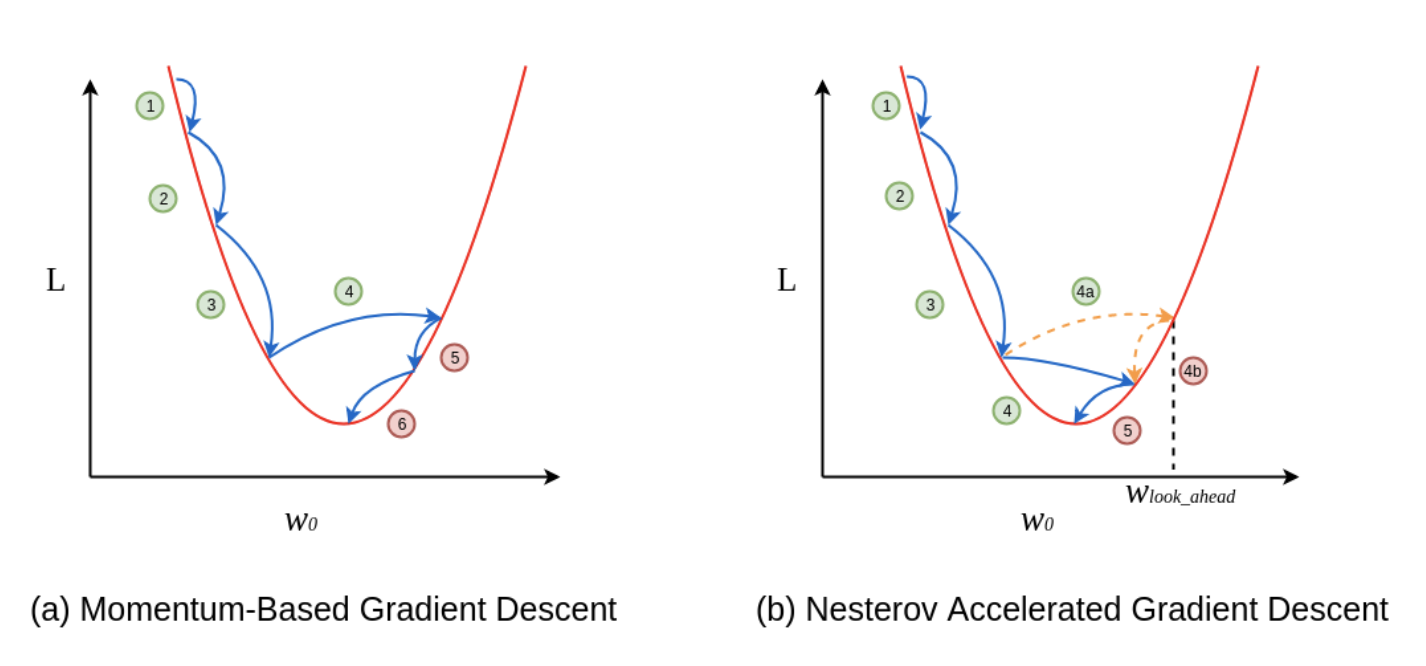

In [64]:
Image(filename="../images/compare_momentum.png") 

Nesterov momentum leads to less severe overshooting, resulting in faster convergence. (Source: [Medium](https://towardsdatascience.com/learning-parameters-part-2-a190bef2d12))

## Annealing the Learning Rate

### Motivation

- we want learning rate to be higher at the beginning so we can avoid getting stuck in bad local minima, and also converge more quickly to a good minima
- once we approach a good minima, we want to anneal (decrease) the learning rate so that we don't have to perform as many oscillations to converge

### Heuristics

**Step Decay**
- reduce learning rate by some factor every few epochs
- in practice, you can train the model with a fixed learning rate, until the validation loss starts to decrease, at which point you reduce it by some factor

**Exponential Decay**
- $\alpha = \alpha_0 e^{-kt}$
- hyperparameters: $\alpha_0$ and $k$
- $t$ is iteration number (can also be in terms of epochs)

**1/t Decay**
- $\alpha = \alpha_0/(1+kt)$
- same notation as exponential decay

In practice, step decay is usually preferred, because its hyperparameters (the number steps before annealing, and the fraction of decay) are more intuitive than $k$. Also, decay on the slower side if you can afford the computational demand, so that you can train longer.

See [machinelearningmastery.com](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/) for good practices and explanation of more heuristics.

## Second-Order Methods

### Newton's Method

**Formula**

$$ W_t = W_{t-1} - [HL]^{-1} \nabla_{W_{t-1}} L$$

- see: [Why do we need to find the inverse of a Hessian in second order optimization?](https://math.stackexchange.com/q/2710463/155812)

**How It Works**

The Hessian matrix $HL$ is the $N \times N$ Jacobian of the gradient, where $N$ is the number of weights. We can think of each column of the Hessian as the amount of influence each weight has on the gradient. Since the Hessian is computed using second-order derivatives, it describes the local curvature in greater detail. Whereas the first derivative (the gradient) tells us the direction of steepest descent, the second derivative, intuitively, tells us how steep the slope is.

This excellent [blog post](https://mlexplained.com/2018/02/02/an-introduction-to-second-order-optimization-for-deep-learning-practitioners-basic-math-for-deep-learning-part-1/) describes the mathematical intuition, with connections to linear algebra and the geometrical interpretation of this method.

**Pros**

Roughly speaking, Newton's method allows us to take greater steps when the slope is shallow (to prevent slow convergence and getting stuck at bad local minima), and smaller steps when the slope is steep (to prevent overshooting). This allows for **faster convergence**. Notice also that the function does not depend on learning rate, so we are dealing with **fewer hyperparameters** as well.

**Cons**
- computing the Hessian, if it exists, is extremely expensive, $O(N^2)$ in space and time
- computing the second derivative analytically is difficult and may even be intractable
- current methods do not work well for mini-batching, thus require training over entire batches, further adding to computation cost
- current methods are sensitive to noise and stochastic functions (so augmentations such as dropout must be disabled during training)

See: (i) [Karpathy's brief explanation on the impracticalities of second-order methods](https://youtu.be/hd_KFJ5ktUc?t=1980), (ii) [Why second order SGD convergence methods are unpopular for deep learning?](https://stats.stackexchange.com/a/394108/291688), (iii) [Why is Newton's method not widely used in machine learning?](https://stats.stackexchange.com/q/253632/291688)

## Per-parameter Adaptive Learning Rate Methods

### Motivation

As discussed in the previous section on annealing learning rate, an ideal learning rate is one that decreases over time, skipping over worse local minima, and then slows down towards a good solution to allow for converging. Furthermore, tuning learning rate is an expensive process, so finding a function that can dynamically update the learning rate during training is appealing.

### Adagrad

**Formula**

1. Store the per-parameter running squared loss:
$$s_t = s_{t-1} + (\nabla_{W_{t-1}} L)^2$$


2. Normalize gradient descent with that sum:
$$W_t = W_{t-1} + \frac{\alpha \nabla_{W_{t-1}} L}{\sqrt{s_t} + \epsilon}$$

Note: We omit the per-parameter index for simplicity, but each $W_t$ is really $W_t^{[i]}$, for the $i$-th weight.

Note: $\epsilon$ is for numerical stability, to avoid division by 0.

**How It Works**

A particular weight which would have normally received frequent or large updates will have that update scaled down due to the increased denominator. On the other hand, a weight which would received small or infrequent updates won't be scaled as harshly.

**Pros**

The normalized per-parameter updates reduces overshooting and speeds up convergence. And since convergence of each parameter is independent, Adagrad works well on sparsely distributed parameters, in comparison to the globally equal updates at each step of SGD.

**Cons**

The monotonicity of the denominator means, after enough steps, the learning rates will be scaled down to negligble values. This can lead to learning rates which converge too quickly, with near-zero parameter gradients early in training.

### RMSprop

**Formula**

1. Compute running average of squared gradient:

$$s_t = \beta s_{t-1} + (1-\beta)(\nabla_{W_{t-1}} L)^2$$


2. Same as Adagrad

**How It Works**

RMSprop attempts to reduce the aggressive monotonicity of Adagrad by introducing a decay rate, similar to the momentum parameter $\beta$. This changes the running sum into an exponentially weighted sum (we can also interpret this as a **weighted average** between the previous sum and the previous gradient).

**RMSprop > Adagrad**

RMSprop enjoys the same pros of faster convergence and smoother loss trajectory. Also, the modified $s_t$ term does not increase at the same rate as in Adagrad, i.e., the learning rates will not be reduced as quickly.

### Adam

**Formula**

1. Compute running average of gradient:

$$m_t = \beta_1 m_{t-1} + (1-\beta_1)\nabla_{W_{t-1}}L$$


2. Compute running average of squared gradient:

$$v_t = \beta_2 v_{t-1} + (1-\beta_2)(\nabla_{W_{t-1}} L)^2$$


3. Update position as in RMSprop, using averaged gradient instead of raw.

$$W_t = m_t + \frac{\alpha \nabla_{W_{t-1}} L}{\sqrt{v_t} + \epsilon}$$

**How It Works**

Adam take the moving average idea one step farther than RMSprop, applying it to both the first and second-order gradient sums, denoted by $m$ and $v$, respectively.

**Pros**

Averaging the first-order gradient sum helps to further reduce noisy data. Again, because of the monotone denominator in the second term of equation 3, the longer we train, the smaller each update becomes (generally). I.e., the earlier updates are more impactful. Adam helps reduce the impact of incorrect initial steps, which could have otherwise extended training time, or even diverged. Intuitively, we can think of this additional correction as turning the ball (using the analogy from momentum) into a [heavy ball](https://ruder.io/optimizing-gradient-descent/index.html#adam) that experiences high friction.

**Cons**

Other than the additional momentum hyperparameter introduced for $m$ (which doesn't appear to be as much of a drawback, due to high-performing defaults commonly used in practice), Adam appears to have better average performance than other optimizers.

**Bias Correction**

Similar to the discussion on bias in the momentum section, the initalization of $m_0 = v_0 = 0$ means the first few updates will be biased towards zero (watch [Andrew Ng's](https://youtu.be/lWzo8CajF5s) explanation for further intuition). Therefore, a fully correct optimization of Adam bias corrects $m$ and $v$:

1. $\hat{m_t} = m_t \,/\, (1-\beta_1^t)$
2. $\hat{v_t} = v_t \,/\, (1-\beta_2^t)$

The logic of the derivation is analagous to that of standard momentum.

1. apply expectation to both sides of the summed versions of the above formulas (see [YouTube](https://youtu.be/-0ZMU-gnm2g?t=341)).

2. factor out the per-step gradient
    - if we assume the respective moment is 0 (where expectation of gradient in $m$ is the first moment, or mean, and the expectation of gradient in $v$ is the second moment, or variance), then the per-step gradient is identically distributed, so they have the same expectation, and the error term becomes 0
    - section 3 of the [original paper on Adam](https://arxiv.org/pdf/1412.6980v8.pdf) mentions that if the moment were non-zero, then the error term will still be small since exponential decay heavily reduces the older terms, i.e., our expected accuracy of our estimator improves with training time

3. divide the expectation of estimators $m$ and $v$ by $(1-\beta_{1}^t)$ and $(1-\beta_{2}^t)$ respectively.

**In Practice**
- recommended values
    - $\epsilon = 1\text{e}{-8}$
    - $\beta_1 = 0.9$
    - $\beta_2 = 0.999$


- recommended methods
    - Adam (which tends to outperform RMSprop) or Nesterov Momentum